/tmp/ipython-input-260344954.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start='2020-01-01', end='2025-12-01')
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Melhores parâmetros: (32, 1, 30)
Loss do GridSearch: 5.726624294766225e-05
Epoch 1 Loss: 0.00423
Epoch 2 Loss: 0.00034
Epoch 3 Loss: 0.00021
Epoch 4 Loss: 0.00057
Epoch 5 Loss: 0.00034
Epoch 6 Loss: 0.00030
Epoch 7 Loss: 0.00024
Epoch 8 Loss: 0.00025
Epoch 9 Loss: 0.00028
Epoch 10 Loss: 0.00008
Epoch 11 Loss: 0.00027
Epoch 12 Loss: 0.00015
Epoch 13 Loss: 0.00035
Epoch 14 Loss: 0.00011
Epoch 15 Loss: 0.00020
Epoch 16 Loss: 0.00043
Epoch 17 Loss: 0.00006
Epoch 18 Loss: 0.00006
Epoch 19 Loss: 0.00043
Epoch 20 Loss: 0.00005
Epoch 21 Loss: 0.00005
Epoch 22 Loss: 0.00008
Epoch 23 Loss: 0.00002
Epoch 24 Loss: 0.00004
Epoch 25 Loss: 0.00025
Epoch 26 Loss: 0.00055
Epoch 27 Loss: 0.00003
Epoch 28 Loss: 0.00008
Epoch 29 Loss: 0.00007
Epoch 30 Loss: 0.00030
Epoch 31 Loss: 0.00003
Epoch 32 Loss: 0.00010
Epoch 33 Loss: 0.00016
Epoch 34 Loss: 0.00012
Epoch 35 Loss: 0.00017
Epoch 36 Loss: 0.00020
Epoch 37 Loss: 0.00007
Epoch 38 Loss: 0.00008
Epoch 39 Loss: 0.00009
Epoch 40 Loss: 0.00006
Epoch 41 Loss:

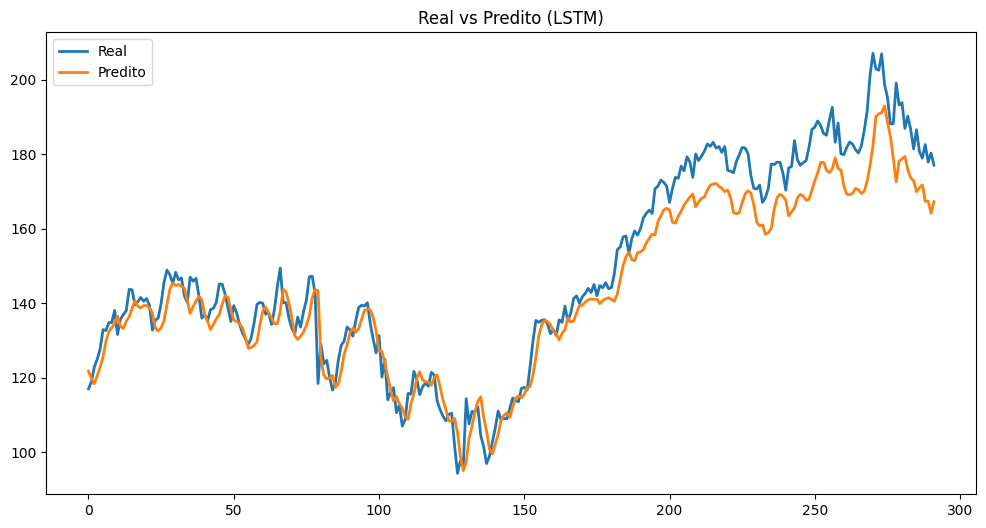

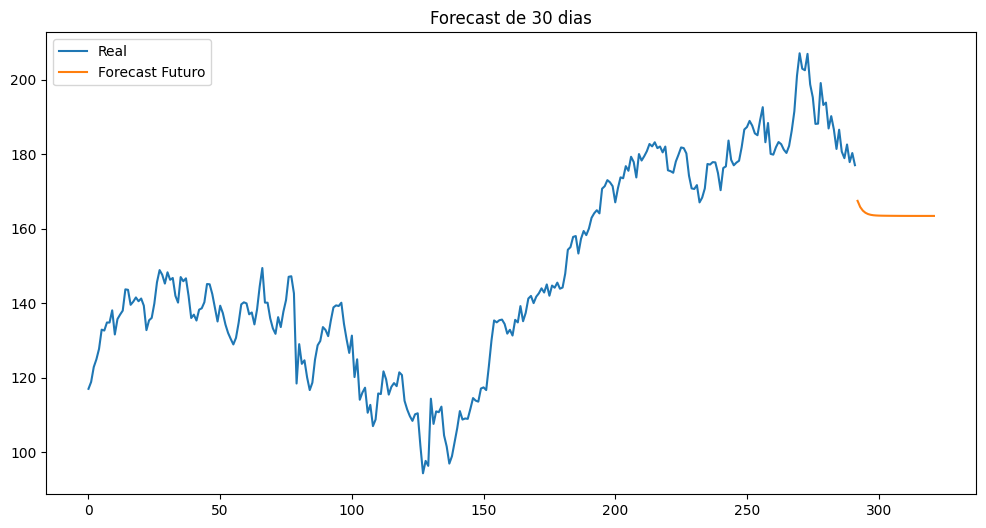

In [4]:

import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from itertools import product
import matplotlib.pyplot as plt


# =====================================
# 1. COLETA DE DADOS
# =====================================
symbol = 'NVDA'
df = yf.download(symbol, start='2020-01-01', end='2025-12-01')
features = ['Open', 'High', 'Low', 'Close', 'Volume']
df = df[features].dropna()

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df)


# =====================================
# 2. FUNÇÃO PARA CRIAÇÃO DE SEQUÊNCIAS
# =====================================
def create_sequences(data, window=60):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i])  # Todas as features como input
        y.append(data[i, 3])  # Apenas 'Close' (índice 3) como target
    return np.array(X), np.array(y)
X, y = create_sequences(scaled)


# =====================================
# 3. MODELO LSTM
# =====================================
class LSTMModel(nn.Module):
    def __init__(self, input_size=5, hidden_size=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)

model = LSTMModel(input_size=5)


# =====================================
# 4. GRIDSEARCH
# =====================================
param_grid = {
    'hidden_size': [32, 64],
    'layers': [1, 2],
    'window': [30, 60]
}

results = []

for hidden_size, layers, window in product(*param_grid.values()):

    X, y = create_sequences(scaled, window)

    split = int(len(X) * 0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Adiciona dimensão

    loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(X_train_t, y_train_t),
        batch_size=32, shuffle=True
    )

    model = LSTMModel(input_size=5, hidden_size=hidden_size, num_layers=layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(10):  # rápido apenas para gridsearch
        for xb, yb in loader:
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()

    results.append(((hidden_size, layers, window), loss.item()))

best_params, best_loss = sorted(results, key=lambda x: x[1])[0]
hidden_size, layers, window = best_params

print("Melhores parâmetros:", best_params)
print("Loss do GridSearch:", best_loss)


# =====================================
# 5. TREINAMENTO FINAL COM MELHOR COMBINAÇÃO
# =====================================
# Recriar sequências com os melhores parâmetros
X, y = create_sequences(scaled, window)

split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

dataset = torch.utils.data.TensorDataset(X_train_t, y_train_t)

loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=32, shuffle=True
)

model = LSTMModel(input_size=5, hidden_size=hidden_size, num_layers=layers)




criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(100):
    for xb, yb in loader:
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1} Loss: {loss.item():.5f}")


# =====================================
# 6. AVALIAÇÃO
# =====================================
model.eval()
with torch.no_grad():
    preds = model(X_test_t).numpy()

# Inverter transformação apenas para a coluna Close
# Criar array temporário com todas as features para inverse_transform
preds_full = np.zeros((len(preds), 5))
preds_full[:, 3] = preds.flatten()  # Coluna Close (índice 3)
preds_original = scaler.inverse_transform(preds_full)[:, 3]

y_test_full = np.zeros((len(y_test), 5))
y_test_full[:, 3] = y_test
y_test_original = scaler.inverse_transform(y_test_full)[:, 3]

# =====================================
# 7. GRÁFICO REAL VS PREDITO
# =====================================
plt.figure(figsize=(12,6))
plt.plot(y_test_original, label="Real", linewidth=2)
plt.plot(preds_original, label="Predito", linewidth=2)
plt.title("Real vs Predito (LSTM)")
plt.legend()
plt.show()


# =====================================
# 8. PREVISÃO FUTURA (FORECAST)
# =====================================
def forecast_future(model, last_sequence, steps, window_size):
    seq = last_sequence.copy()
    preds = []

    for _ in range(steps):
        x = torch.tensor(seq.reshape(1, window_size, 5), dtype=torch.float32)  # 5 features
        with torch.no_grad():
            y_pred = model(x).numpy()

        preds.append(y_pred[0][0])
        # Atualizar sequência: remover primeira linha e adicionar nova com predição
        # Criar nova linha com todas as features (usar valores da última linha e atualizar Close)
        new_row = seq[-1].copy()
        new_row[3] = y_pred[0][0]  # Atualizar Close (índice 3)
        seq = np.append(seq[1:], [new_row], axis=0)

    return np.array(preds)

last_seq = scaled[-window:]
future_preds = forecast_future(model, last_seq, steps=30, window_size=window)

# Inverter transformação apenas para Close
future_preds_full = np.zeros((len(future_preds), 5))
future_preds_full[:, 3] = future_preds  # Coluna Close (índice 3)
future_preds_original = scaler.inverse_transform(future_preds_full)[:, 3]


# =====================================
# 9. GRÁFICO FORECAST FUTURO
# =====================================
plt.figure(figsize=(12,6))
plt.plot(range(len(y_test_original)), y_test_original, label="Real")
plt.plot(range(len(y_test_original), len(y_test_original)+30), future_preds_original, label="Forecast Futuro")
plt.title("Forecast de 30 dias")
plt.legend()
plt.show()
